# Predicting Work Placement Status using Academic Percentages
DSCI 100 Project Proposal \
**Group 005-32**: Imanjosh Chahal, Kahsennaró-roks Deom, Romina Mahinpei

## Introduction

For most students, getting a work placement is of great concern. Students constantly work on obtaining qualities that employers will consider when hiring, such as volunteering, making connections, etc. However, students mostly work on obtaining high academic averages so that it can be recognized by employers and lead them to secure a work placement. Seeing this cycle, we chose to take on a classification project and formed the following research question: **can we predict whether an employer will hire students based on their secondary school, high school, undergrad degree, MBA degree, and employability test percentages?**
The dataset used to answer this question is the [Placement_Data_Full_Class](https://www.kaggle.com/benroshan/factors-affecting-campus-placement), collected by Jain University in Bangalore. The dataset contains 15 variables and 215 observations.

## Preliminary Exploratory Data Analysis
We begin the exploration by loading packages and reading the dataset from the web.

In [2]:
# load packages
library(tidyverse)
library(tidymodels)
library(repr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [4]:
# load data
data_url <- "https://raw.githubusercontent.com/DG1606/CMS-R-2020/7f00d6b5e20d99a933c582d8b544fc4d04528462/Placement_Data_Full_Class.csv"
data_original <- read_csv(data_url)
head(data_original)

Parsed with column specification:
cols(
  sl_no = col_double(),
  gender = col_character(),
  ssc_p = col_double(),
  ssc_b = col_character(),
  hsc_p = col_double(),
  hsc_b = col_character(),
  hsc_s = col_character(),
  degree_p = col_double(),
  degree_t = col_character(),
  workex = col_character(),
  etest_p = col_double(),
  specialisation = col_character(),
  mba_p = col_double(),
  status = col_character(),
  salary = col_double()
)



sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000
2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000
3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000
4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NA
5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000
6,M,55.00,Others,49.80,Others,Science,67.25,Sci&Tech,Yes,55.0,Mkt&Fin,51.58,Not Placed,NA


We note that the data is already in tidy format since it meets the following requirements:
* Each variable forms a column.
* Each observation forms a row.
* Each cells represents a single measurement.

However, since we will treat the "status" variable as our label later in the analysis, we change its column type to a factor. We also split the data into a testing set (25% of original data) and a training set (75% of original data). We then summarize the training data in a table.

In [23]:
# treat status as a factor
data_original <- mutate(data_original, status = as_factor(status))

# split data into testing and training sets
data_split <- initial_split(data_original, prop = 0.75, strata = status)
data_train <- training(data_split)
data_test <- testing(data_split)

In [24]:
# summarize training data
summary_table <- data_train %>%
    select(status, ssc_p, hsc_p, degree_p, mba_p, etest_p) %>%
    group_by(status) %>%
    summarize(count = n(), 
              mean_ssc_p = mean(ssc_p), 
              mean_hsc_p = mean(hsc_p), 
              mean_degree_p = mean(degree_p), 
              mean_mba_p = mean(mba_p), 
              mean_etest_p = mean(etest_p))
summary_table

`summarise()` ungrouping output (override with `.groups` argument)



status,count,mean_ssc_p,mean_hsc_p,mean_degree_p,mean_mba_p,mean_etest_p
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Placed,111,72.21685,70.52640,68.73928,62.74919,73.78459
Not Placed,51,57.01373,58.75843,61.25804,61.16039,71.27451


We observe that Placed students appear to have higher average academic percentages than Not Placed students. This suggests that students can indeed be classified into two binary groups (Placed vs. Not Placed) based on their academic percentages, thus making this scenario an ideal candidate for classification. 

We further highlight that our dataset is an ideal candidate for classification by creating histograms to show the distribution of our predictors for each of the two levels of our label (Placed vs. Not Placed). We again observe that Placed students appear to have higher average academic percentages than Not Placed students. 

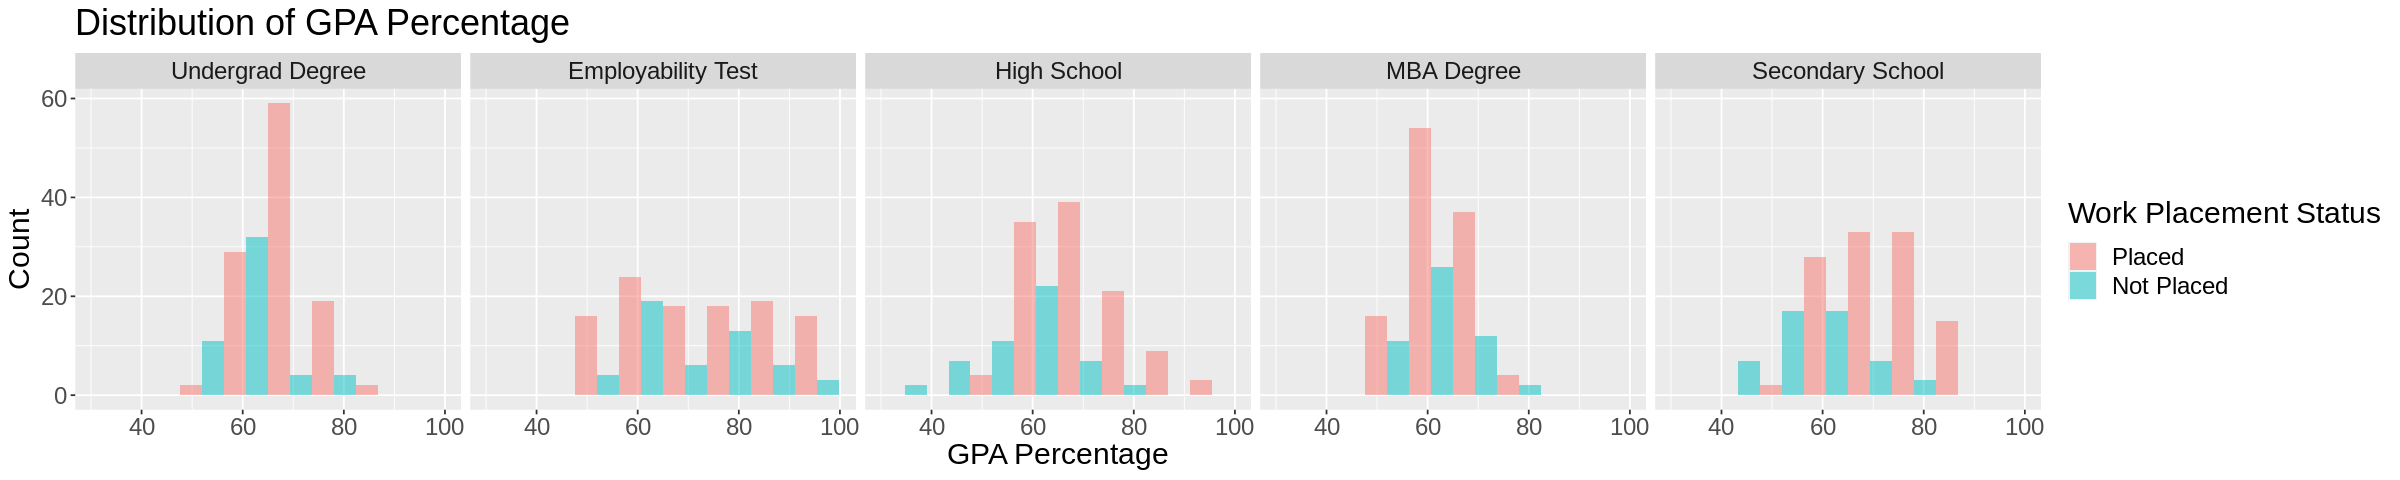

In [20]:
options(repr.plot.width = 20, repr.plot.height = 4)

# adjust data format so that facet_grid can be applied
data_plot <- data_train %>%
    select(status, ssc_p, hsc_p, degree_p, mba_p, etest_p) %>%
    pivot_longer(cols = ssc_p:etest_p,
                 names_to = "degree_type",
                 values_to = "gpa_p")

gpa_labels <- c(ssc_p = "Secondary School", 
                hsc_p = "High School", 
                degree_p = "Undergrad Degree",
                mba_p = "MBA Degree", 
                etest_p = "Employability Test")

# create histograms to show distributions of predictors
distribution_predictors <- ggplot(data_plot, aes(x = gpa_p, fill = status)) +
    geom_histogram(bins = 8, alpha = 0.5, position = "dodge") + 
    labs(x = "GPA Percentage", y = "Count", fill = "Work Placement Status") +
    facet_grid(. ~ degree_type, labeller = labeller(degree_type = gpa_labels)) + 
    ggtitle("Distribution of GPA Percentage") +
    theme(text = element_text(size = 18))
distribution_predictors

## Methods
We plan to use secondary school, high school, undergrad degree, MBA degree, and employability test percentages to predict whether a student will receive a work placement position or not. Thus, we will use ssc_p, hsc_p, degree_p, mba_p, and etest_p variables as our five predictors and treat the status column as our target variable. To verify that our predictors are relevant variables, we paired our predictors in all possible combinations (e.g. hsc_p & degree_p, etc.) and created a scatterplot each time. A sample scatterplot from this process is provided below.

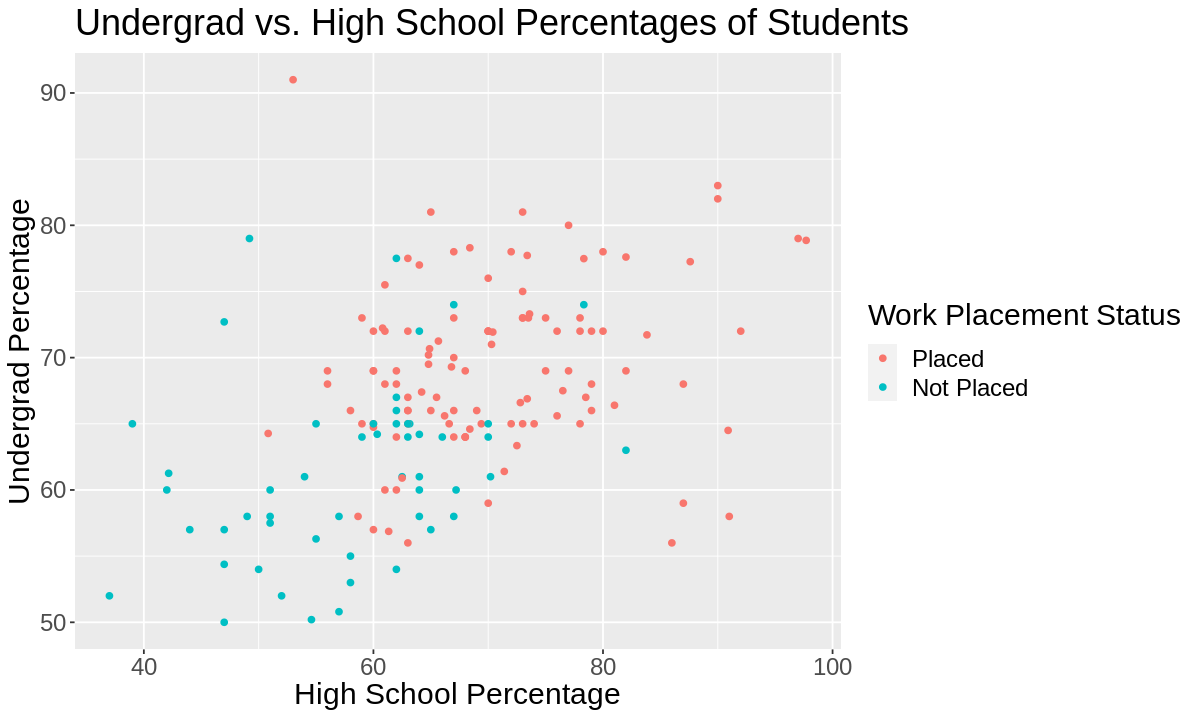

In [22]:
options(repr.plot.width = 10, repr.plot.height = 6)

scatterplot <- ggplot(data_train, aes(x = hsc_p, y = degree_p, color = status)) +
    geom_point() +
    labs(color = "Work Placement Status") +
    xlab("High School Percentage") +
    ylab("Undergrad Percentage") +
    ggtitle("Undergrad vs. High School Percentages of Students") +
    theme(text = element_text(size = 18))
scatterplot

In all scatterplots, we observe distinct clusters for the two levels of our target variable. This assures us that our chosen predictors are relevant and can be used in our classification model.

As for training our classification model, we will use the K-nearest neighbours algorithm. We will visualize our data using scatterplots. Similar to above, we will pair our predictors (e.g. hsc_p & degree_p, etc.) and treat one predictor from the pair as the variable on the x-axis and the other predictor as the variable on the y-axis and also colour our points based on their labels (Placed vs. Non-Placed).

## Expected Outcomes & Significance
From our preliminary exploration, we observed that students appeared in distinct clusters. The cluster of Placed students often had  higher academic averages than the cluster of Not Placed students. These observations lead us to belive that work placement can be predicted using academic percentages.

These findings are impactful since it will be beneficial for students to have a idea on whether they will recieve a work placement based on their academic percentages. Based on these predictions, students will know whether they should maintain or change their study habits in order to improve their academic percentages.

## Future Questions
After concluding this project, it would be interesting to investigate whether our results apply to other countries. We acknowledge that our dataset only contains information on Indian students,  so our results may not apply to student from other countries. By conducting this investigation with datasets from different countries, we will see whether work placement status can/cannot be predicted from academic percentages in most regions or whether these results are only applicable to certain regions.